### Prepare audioset and some key hyperparameters

In [1]:
import pandas as pd

datapath = "/data/lujd/algorithm2022/audioset/"
train_df = pd.read_csv(datapath+"train.csv", sep="\t")
dev_df = pd.read_csv(datapath+"dev.csv", sep="\t")
eval_df = pd.read_csv(datapath+"eval.csv", sep="\t")

unique_labels = ['airport', 'bus', 'metro', 'metro_station',
                'park', 'public_square', 'shopping_mall',
                'street_pedestrian', 'street_traffic', 'tram']
label_dict = {}
for ind, c in enumerate(unique_labels):
    label_dict[c] = ind

#### 1. use diag covariance

In [2]:
n_mels = 26             # 26 is better than 40
feature_option = "mfcc"
gmm_n_components = 8    # 8 is better than 4
gmm_covariance_type = 'diag'

Train

In [3]:
# extract feature
import numpy as np
from Extract_feature import extract_mfcc

# train set
train_files = list(train_df.filename)
train_labels = list(train_df.scene_label)
train_features = []
for filename in train_files:
    wav_file_path = datapath+filename
    mfcc_feature = extract_mfcc(wav_file_path, n_mels=n_mels, option=feature_option)
    train_features.append(mfcc_feature.reshape(1,-1))           # [1, frames*n_features] (flatten)
train_features = np.concatenate(train_features, axis=0)
print(f"train feature size: {train_features.shape}")

# dev set
dev_files = list(dev_df.filename)
dev_labels = list(dev_df.scene_label)
dev_labels = [label_dict[c] for c in dev_labels]
dev_features = []
for filename in dev_files:
    wav_file_path = datapath+filename
    mfcc_feature = extract_mfcc(wav_file_path, n_mels=n_mels, option=feature_option)
    dev_features.append(mfcc_feature.reshape(1,-1))             # [1, frames*n_features] (flatten)
dev_features = np.concatenate(dev_features, axis=0)
print(f"dev feature size: {dev_features.shape}")

train feature size: (3008, 6487)
dev feature size: (379, 6487)


In [4]:
# train GMMs for each class
import numpy as np
from sklearn.mixture import GaussianMixture

gmm_classifier_dict = {}
start_pos, end_pos = 0, 0
for ind, c in enumerate(unique_labels):
    target_df = train_df[train_df.scene_label==c]
    end_pos += len(target_df)
    # print(start_pos, end_pos)
    gmm = GaussianMixture(n_components=gmm_n_components, max_iter=100, n_init=3, tol=1e-3,
                        covariance_type=gmm_covariance_type, init_params="kmeans", random_state=0)
    gmm.fit(train_features[start_pos:end_pos,:])
    start_pos = end_pos
    print(f"{ind}-best iteration: {gmm.n_iter_}")
    gmm_classifier_dict[ind] = gmm

0-best iteration: 12
1-best iteration: 10
2-best iteration: 6
3-best iteration: 23
4-best iteration: 9
5-best iteration: 6
6-best iteration: 7
7-best iteration: 7
8-best iteration: 7
9-best iteration: 8


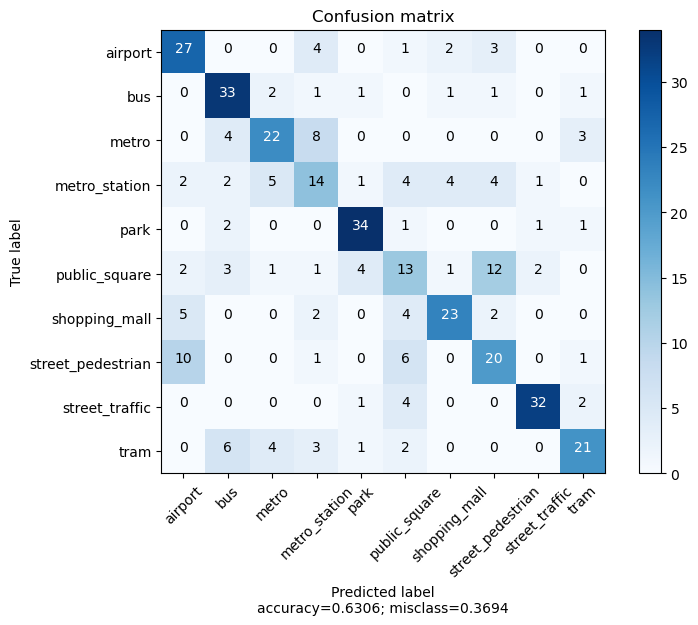

In [5]:
# dev
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

# find max score
pre_scores_list = []
for i in label_dict.values():
    pre_scores = gmm_classifier_dict[i].score_samples(dev_features)
    pre_scores_list.append(pre_scores.reshape(1,-1))
    # print(pre_scores.shape)
pre_scores_list = np.concatenate(pre_scores_list, axis=0)
dev_pre_labels = np.argmax(pre_scores_list, axis=0)

dev_true_labels = np.asarray(dev_labels)
dev_cm = confusion_matrix(dev_true_labels, dev_pre_labels)
# dev_cm_df = pd.DataFrame(dev_cm, columns=label_dict.keys(), index=label_dict.keys())
# dev_cm_df
plot_confusion_matrix(dev_cm, label_dict.keys())

In [6]:
dev_acc_df = pd.DataFrame()
for c, i in label_dict.items():
    acc = dev_cm[i,i] / np.sum(dev_cm[i])
    dev_acc_df[c] = [acc]
dev_acc_df["all"] = np.trace(dev_cm) / float(np.sum(dev_cm))
dev_acc_df.rename(index={0: "accurary"})
dev_acc_df

,airport,bus,metro,metro_station,park,public_square,shopping_mall,street_pedestrian,street_traffic,tram,all
0,0.72973,0.825,0.594595,0.378378,0.871795,0.333333,0.638889,0.526316,0.820513,0.567568,0.630607


Test on eval set

In [8]:
# extract feature
eval_files = list(eval_df.filename)
eval_labels = list(eval_df.scene_label)
eval_labels = [label_dict[c] for c in eval_labels]
eval_features = []
for filename in eval_files:
    wav_file_path = datapath+filename
    mfcc_feature = extract_mfcc(wav_file_path, n_mels=n_mels, option=feature_option)
    eval_features.append(mfcc_feature.reshape(1,-1))             # [1, frames*n_features] (flatten)
eval_features = np.concatenate(eval_features, axis=0)
print(f"eval feature size: {eval_features.shape}")

eval feature size: (330, 6487)


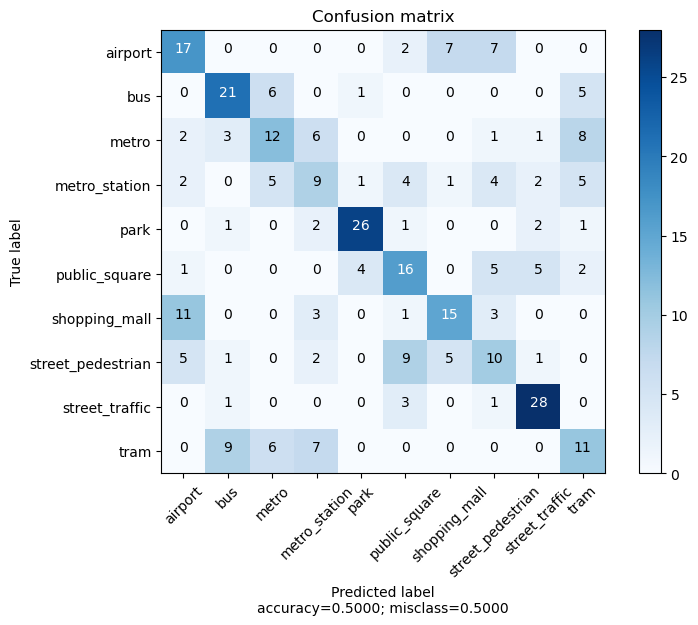

In [8]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

# find max score
pre_scores_list = []
for i in label_dict.values():
    pre_scores = gmm_classifier_dict[i].score_samples(eval_features)
    pre_scores_list.append(pre_scores.reshape(1,-1))
    # print(pre_scores.shape)
pre_scores_list = np.concatenate(pre_scores_list, axis=0)
eval_pre_labels = np.argmax(pre_scores_list, axis=0)

eval_true_labels = np.asarray(eval_labels)
eval_cm = confusion_matrix(eval_true_labels, eval_pre_labels)
# eval_cm_df = pd.DataFrame(eval_cm, columns=label_dict.keys(), index=label_dict.keys())
# eval_cm_df
plot_confusion_matrix(eval_cm, label_dict.keys())

In [9]:
eval_acc_df = pd.DataFrame()
for c, i in label_dict.items():
    acc = eval_cm[i,i] / np.sum(eval_cm[i])
    eval_acc_df[c] = [acc]
eval_acc_df["all"] = np.trace(eval_cm) / float(np.sum(eval_cm))
eval_acc_df.rename(index={0: "accurary"})
eval_acc_df

,airport,bus,metro,metro_station,park,public_square,shopping_mall,street_pedestrian,street_traffic,tram,all
0,0.515152,0.636364,0.363636,0.272727,0.787879,0.484848,0.454545,0.30303,0.848485,0.333333,0.5


#### 2. use full covariance

In [4]:
n_mels = 26             # 26 is better than 40
feature_option = "mfcc"
gmm_n_components = 8    # 8 is better than 4
gmm_covariance_type = 'full'

Train

In [5]:
# train GMMs for each class
import numpy as np
from sklearn.mixture import GaussianMixture

gmm_classifier_dict = {}
start_pos, end_pos = 0, 0
for ind, c in enumerate(unique_labels):
    target_df = train_df[train_df.scene_label==c]
    end_pos += len(target_df)
    # print(start_pos, end_pos)
    gmm = GaussianMixture(n_components=gmm_n_components, max_iter=100, n_init=3, tol=1e-3,
                        covariance_type=gmm_covariance_type, init_params="kmeans", random_state=0)
    gmm.fit(train_features[start_pos:end_pos,:])
    start_pos = end_pos
    print(f"{ind}-best iteration: {gmm.n_iter_}")
    gmm_classifier_dict[ind] = gmm

0-best iteration: 2
1-best iteration: 2
2-best iteration: 2
3-best iteration: 2
4-best iteration: 2
5-best iteration: 2
6-best iteration: 2
7-best iteration: 2
8-best iteration: 2
9-best iteration: 2


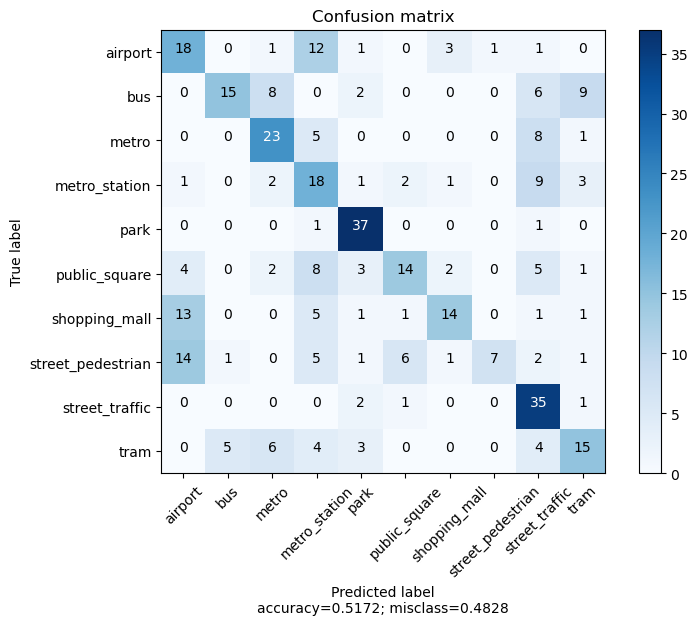

In [6]:
# dev
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

# find max score
pre_scores_list = []
for i in label_dict.values():
    pre_scores = gmm_classifier_dict[i].score_samples(dev_features)
    pre_scores_list.append(pre_scores.reshape(1,-1))
    # print(pre_scores.shape)
pre_scores_list = np.concatenate(pre_scores_list, axis=0)
dev_pre_labels = np.argmax(pre_scores_list, axis=0)

dev_true_labels = np.asarray(dev_labels)
dev_cm = confusion_matrix(dev_true_labels, dev_pre_labels)
# dev_cm_df = pd.DataFrame(dev_cm, columns=label_dict.keys(), index=label_dict.keys())
# dev_cm_df
plot_confusion_matrix(dev_cm, label_dict.keys())

In [7]:
dev_acc_df = pd.DataFrame()
for c, i in label_dict.items():
    acc = dev_cm[i,i] / np.sum(dev_cm[i])
    dev_acc_df[c] = [acc]
dev_acc_df["all"] = np.trace(dev_cm) / float(np.sum(dev_cm))
dev_acc_df.rename(index={0: "accurary"})
dev_acc_df

,airport,bus,metro,metro_station,park,public_square,shopping_mall,street_pedestrian,street_traffic,tram,all
0,0.486486,0.375,0.621622,0.486486,0.948718,0.358974,0.388889,0.184211,0.897436,0.405405,0.51715


Test on eval set

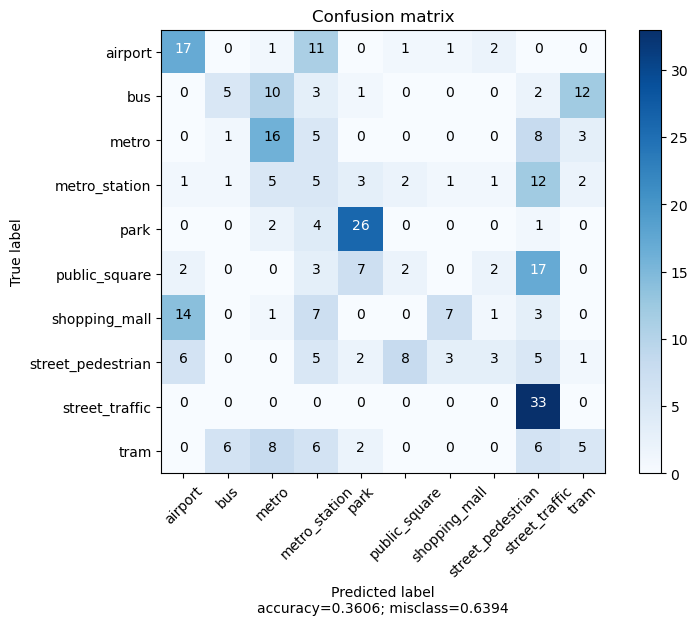

In [9]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

# find max score
pre_scores_list = []
for i in label_dict.values():
    pre_scores = gmm_classifier_dict[i].score_samples(eval_features)
    pre_scores_list.append(pre_scores.reshape(1,-1))
    # print(pre_scores.shape)
pre_scores_list = np.concatenate(pre_scores_list, axis=0)
eval_pre_labels = np.argmax(pre_scores_list, axis=0)

eval_true_labels = np.asarray(eval_labels)
eval_cm = confusion_matrix(eval_true_labels, eval_pre_labels)
# eval_cm_df = pd.DataFrame(eval_cm, columns=label_dict.keys(), index=label_dict.keys())
# eval_cm_df
plot_confusion_matrix(eval_cm, label_dict.keys())

In [10]:
eval_acc_df = pd.DataFrame()
for c, i in label_dict.items():
    acc = eval_cm[i,i] / np.sum(eval_cm[i])
    eval_acc_df[c] = [acc]
eval_acc_df["all"] = np.trace(eval_cm) / float(np.sum(eval_cm))
eval_acc_df.rename(index={0: "accurary"})
eval_acc_df

,airport,bus,metro,metro_station,park,public_square,shopping_mall,street_pedestrian,street_traffic,tram,all
0,0.515152,0.151515,0.484848,0.151515,0.787879,0.060606,0.212121,0.090909,1.0,0.151515,0.360606
